# Smart Device Human Activity Recognition (HAR) Model (Using Feature Engineering?)

[Eugene Zen](mailto:ezen@ucsd.edu), [Shane Luna](mailto:shluna@ucsd.edu)

## I. Summary
This notebook presents the development of a Human Activity Recognition (HAR) model that utilizes sensors from both smartphones and smartwatches. The data was originally collected and analyzed by the members of the WISDM (Wireless Sensor Data Mining) Lab in the Department of Computer and Information Science of Fordham University. More information on the original experiment can be found in the publication from 2019 [here](https://ieeexplore.ieee.org/document/8835065). The data was made publicly available on the UCI Machine Learning Repository as the "WISDM Smartphone and Smartwach Activity and Biometrics Dataset" and can be found [here](https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+).

## II. Development

### Dependencies

In [132]:
%matplotlib inline

from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import string

In [2]:
# Start local dask client
client = Client(n_workers=4)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:38475 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 15.64 GiB


### Load Data

In [337]:
def read_file(filepath):
    df = dd.read_csv(filepath, sep = ',', header = None)
    df.columns = ['subject_id', 'activity_code', 'timestamp', 'x', 'y', 'z']
    df['timestamp_dt'] = dd.to_datetime(df['timestamp'])
    df['z'] = df['z'].str.replace(";","").astype('float64') # remove ; and ensure float (having issues with lineterminator)
    return df

In [338]:
# Phone Data
phone_accel_df = read_file('wisdm-dataset/raw/phone/accel/*.txt')
phone_gyro_df = read_file('wisdm-dataset/raw/phone/gyro/*.txt')

# Watch Data
watch_accel_df = read_file('wisdm-dataset/raw/watch/accel/*.txt')
watch_gyro_df = read_file('wisdm-dataset/raw/watch/gyro/*.txt')

In [339]:
phone_accel_df.head()

,subject_id,activity_code,timestamp,x,y,z,timestamp_dt
0,1600,A,252207666810782,-0.364761,8.793503,1.055084,1970-01-03 22:03:27.666810782
1,1600,A,252207717164786,-0.879730,9.768784,1.016998,1970-01-03 22:03:27.717164786
2,1600,A,252207767518790,2.001495,11.109070,2.619156,1970-01-03 22:03:27.767518790
3,1600,A,252207817872794,0.450623,12.651642,0.184555,1970-01-03 22:03:27.817872794
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485,1970-01-03 22:03:27.868226798


In [330]:
from datetime import datetime
ts = int("252207666810782")
ts /= 1000000

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

1977-12-29 01:41:06


Referring to the dataset description provided from the WISDM Lab, we expect to see the following row counts:

- raw/phone/accel: 4,804,403
- raw/phone/gyro: 3,608,635
- raw/watch/accel: 3,777,046
- raw/watch/gyro: 3,440,342

In [10]:
print(f'Phone Accel:\t{len(phone_accel_df)}')
print(f'Phone Gyro:\t{len(phone_gyro_df)}')
print(f'Watch Accel:\t{len(watch_accel_df)}')
print(f'Watch Gyro:\t{len(watch_gyro_df)}')

Phone Accel:	4804403
Phone Gyro:	3608635
Watch Accel:	3777046
Watch Gyro:	3440342


All of the above dataframes are stuctured the same. A sample output of the column datatypes has been provided below for reference. An additional column, timestamp_dt, was added to the original data by converting the timestamp attribute to a datetime object type. The original timestamp column has been preserved if needed for future enhancements.

In [12]:
print(phone_accel_df.dtypes)

subject_id                int64
activity_code            object
timestamp                 int64
x                       float64
y                       float64
z                       float64
timestamp_dt     datetime64[ns]
dtype: object


### Exploratory Data Analysis

In [26]:
# Check for nulls

print('--Phone Accel--')
print(phone_accel_df.isna().sum().compute())

print('--Phone Gyro--')
print(phone_gyro_df.isna().sum().compute())

print('--Watch Accel--')
print(watch_accel_df.isna().sum().compute())

print('--Watch Gyro--')
print(watch_gyro_df.isna().sum().compute())

--Phone Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Phone Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Accel--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64
--Watch Gyro--
subject_id       0
activity_code    0
timestamp        0
x                0
y                0
z                0
timestamp_dt     0
dtype: int64


In [97]:
def plot_subject_activity(df, title_append=None):
    subject_id = df.head(1)['subject_id'].item()
    activity_code = df.head(1)['activity_code'].item()
    title = f'Subject {subject_id} Performing Activity {activity_code}' 
    if title_append != None:
        title+=str(f' ({title_append})')
        
    fig, ax = plt.subplots(3, figsize=(20,5), sharex=True)
    fig.suptitle(title)
    ax[0].plot(range(len(df)), df['x'].to_numpy(), c='C0')
    ax[0].set_title('x')
    ax[1].plot(range(len(df)), df['y'].to_numpy(), c='C1')
    ax[1].set_title('y')
    ax[2].plot(range(len(df)), df['z'].to_numpy(), c='C2')
    ax[2].set_title('z')
    ax[2].set_xlabel('Interval')

Visualizations have been provided below of tri-axial sensor readings from both a smartphone accelerometer (first) and smarphone gyroscope (second). Our efforts aim to assess the distinctness of these patterns for different physical activities. 

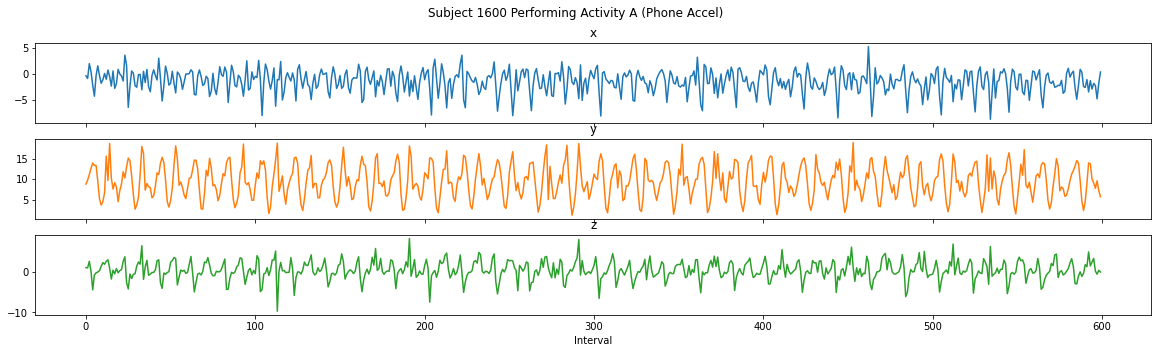

In [101]:
# Sample chart of a user performing an activity for 30 seconds or ~600 intervals @ 20Hz
# Activity A = Walking
activity = phone_accel_df[(phone_accel_df['subject_id'] == 1600) & (phone_accel_df['activity_code'] == "A")].compute()[0:600]
plot_subject_activity(activity, 'Phone Accel')

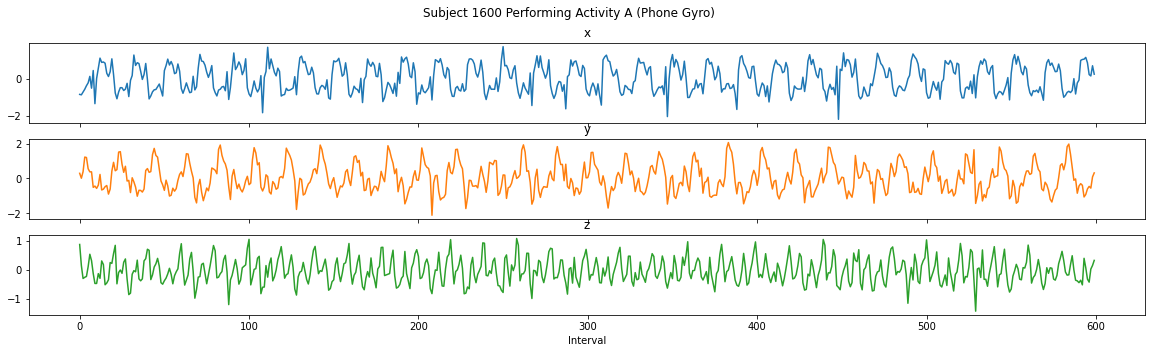

In [102]:
# Sample chart of a user performing an activity for 30 seconds or ~600 intervals @ 20Hz
# Activity A = Walking
activity = phone_gyro_df[(phone_gyro_df['subject_id'] == 1600) & (phone_gyro_df['activity_code'] == 'A')].compute()[0:600]
plot_subject_activity(activity, 'Phone Gyro')

In [152]:
subjects = phone_accel_df['subject_id'].unique().compute()
activities = phone_accel_df['activity_code'].unique().compute()

In [221]:
subject_activities_df = pd.DataFrame(subjects).merge(pd.DataFrame(activities), how='cross')

phone_accel_interval_counts = phone_accel_df.groupby(['subject_id', 'activity_code']).size().rename('phone_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

phone_gyro_interval_counts = phone_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('phone_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(phone_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_accel_interval_counts = watch_accel_df.groupby(['subject_id', 'activity_code']).size().rename('watch_accel').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_accel_interval_counts, on=['subject_id', 'activity_code'], how='left')

watch_gyro_interval_counts = watch_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('watch_gyro').reset_index().compute()
subject_activities_df = subject_activities_df.merge(watch_gyro_interval_counts, on=['subject_id', 'activity_code'], how='left')

subject_activities_df = subject_activities_df.set_index(['subject_id'])

subject_activities_df.isna().sum()

activity_code     0
phone_accel       8
phone_gyro       10
watch_accel       6
watch_gyro       11
dtype: int64

In [231]:
subject_activities_df[subject_activities_df.isna().any(axis=1)]

,activity_code,phone_accel,phone_gyro,watch_accel,watch_gyro
subject_id,,,,,
1607,J,NaN,NaN,3603.0,3602.0
1609,B,NaN,NaN,3605.0,3603.0
1616,B,NaN,NaN,NaN,NaN
1616,F,NaN,NaN,3605.0,3603.0
1618,O,NaN,NaN,NaN,NaN
1637,C,3600.0,3598.0,8931.0,NaN
1637,J,3600.0,3598.0,NaN,NaN
1638,H,3615.0,3613.0,8931.0,NaN
1638,O,3601.0,3599.0,8936.0,NaN


Additional Takeaways:
- Not all subjects performed all activities
- Some subjects may have performed certain activites with limited sensors recording

### Data Preparation

Regarding data preparation, there will be two main tasks:
1. Join the sensor data for each device by timestamp.
2. Break each activity done by a subject into a desired window size (in seconds) to train/test on
    - Aggregate/engineer desired features for each window 

In the WISDM dataset description, it was noted that the data collection process was not perfect and that their actual number of recordings didn't match their expected number of recordings. For example, they are unsure why there are so many more sensor readings for the phone accelerometer. We are placing high trust in the data collection process done by the WISDM Lab team, but are aware that there could be anomalies with an imperfect process. For example, we have already seen above that there is missing activity data for certain subjects and device sensors. That being said, we are trusting that the timestamps among sensors were accurately synced.

Our go-forward approach is going to be to only use device data where it exists for both sensors.

- **to_use_phone_data** = inner join phone_accel and phone_gryo data on timestamp (keep only activites where both sensor data available)
- **to_use_watch_data** = inner join watch_accel and watch_gryo data on timestamp (keep only activites where both sensor data available)

When training a model based on both phone AND watch data, we will use only activity data available with all 4 sensors.

In [237]:
# Phone
phone_combined_df = phone_accel_df.merge(phone_gyro_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
phone_combined_df = phone_combined_df.drop(['timestamp_gyro'], axis=1)
phone_combined_df = phone_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
phone_combined_df.head()

,subject_id,activity_code,timestamp,x_accel,y_accel,z_accel,timestamp_dt,x_gyro,y_gyro,z_gyro
0,1600,A,252208623536856,0.889343,4.531982,-0.228958,1970-01-03 22:03:28.623536856,0.910889,-0.612137,0.197403
1,1600,A,252208875306876,1.651108,13.003159,-2.630463,1970-01-03 22:03:28.875306876,1.082046,0.425598,0.237305
2,1600,A,252212249025138,-0.697052,11.577240,3.471695,1970-01-03 22:03:32.249025138,-0.653595,0.831863,0.515823
3,1600,A,252217435498358,-0.366928,8.423248,3.045731,1970-01-03 22:03:37.435498358,-0.254837,-0.243484,-0.491852
4,1600,A,252217939038397,-7.973221,15.072464,-0.969360,1970-01-03 22:03:37.939038397,-1.388626,-0.085068,0.710587


In [238]:
# Watch
watch_combined_df = watch_accel_df.merge(watch_gyro_df, on=["subject_id", "activity_code", "timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
watch_combined_df = watch_combined_df.drop(['timestamp_gyro'], axis=1)
watch_combined_df = watch_combined_df.rename(columns={'timestamp_accel': 'timestamp'})
watch_combined_df.head()

,subject_id,activity_code,timestamp,x_accel,y_accel,z_accel,timestamp_dt,x_gyro,y_gyro,z_gyro
0,1600,A,90426856696641,2.801216,-0.155922,5.997625,1970-01-02 01:07:06.856696641,0.070999,-0.209480,-0.195978
1,1600,A,90432470714381,9.172187,-1.099238,-1.656638,1970-01-02 01:07:12.470714381,-0.522468,1.546161,0.871395
2,1600,A,90432918723401,10.740389,-5.506963,0.048034,1970-01-02 01:07:12.918723401,2.188615,-0.352129,-2.769682
3,1600,A,90433267234501,11.561600,-1.341052,0.198868,1970-01-02 01:07:13.267234501,-0.189049,1.916880,6.515163
4,1600,A,90435458522181,8.470686,0.672471,-1.699734,1970-01-02 01:07:15.458522181,0.395773,0.778118,2.059161


In [239]:
print(f'Phone: {len(phone_combined_df)}')
print(f'Watch: {len(watch_combined_df)}')

Phone: 2909149
Watch: 3368542


In [243]:
corr_matrix_phone = phone_combined_df.corr()
corr_matrix_phone.compute().style.background_gradient(cmap='coolwarm')

,subject_id,timestamp,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro
subject_id,1.000000,0.596690,0.005462,-0.319758,-0.269785,-0.004315,0.000357,0.006410
timestamp,0.596690,1.000000,0.039603,-0.039545,-0.176558,-0.003824,0.002991,-0.003035
x_accel,0.005462,0.039603,1.000000,0.037617,-0.060545,0.001618,-0.021004,0.012809
y_accel,-0.319758,-0.039545,0.037617,1.000000,0.103309,0.019798,-0.020008,-0.002203
z_accel,-0.269785,-0.176558,-0.060545,0.103309,1.000000,-0.027184,-0.022956,-0.003040
x_gyro,-0.004315,-0.003824,0.001618,0.019798,-0.027184,1.000000,0.008144,0.113085
y_gyro,0.000357,0.002991,-0.021004,-0.020008,-0.022956,0.008144,1.000000,0.086628
z_gyro,0.006410,-0.003035,0.012809,-0.002203,-0.003040,0.113085,0.086628,1.000000


In [244]:
corr_matrix_watch = watch_combined_df.corr()
corr_matrix_watch.compute().style.background_gradient(cmap='coolwarm')

,subject_id,timestamp,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro
subject_id,1.000000,0.534694,-0.011912,0.023180,0.026741,-0.001473,-0.004214,-0.000735
timestamp,0.534694,1.000000,0.005673,0.000108,0.056214,-0.002317,-0.002041,-0.002633
x_accel,-0.011912,0.005673,1.000000,0.012759,-0.083554,-0.038202,-0.123529,-0.068413
y_accel,0.023180,0.000108,0.012759,1.000000,0.082847,0.045854,-0.050834,-0.042866
z_accel,0.026741,0.056214,-0.083554,0.082847,1.000000,0.029104,0.033523,-0.010475
x_gyro,-0.001473,-0.002317,-0.038202,0.045854,0.029104,1.000000,-0.068556,0.110492
y_gyro,-0.004214,-0.002041,-0.123529,-0.050834,0.033523,-0.068556,1.000000,0.200523
z_gyro,-0.000735,-0.002633,-0.068413,-0.042866,-0.010475,0.110492,0.200523,1.000000


In [263]:
phone_grouped_df = combined_phone_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')])

In [269]:
# more work to be done on the group by still; timestamps may be off for certain devices

In [302]:
size = phone_grouped_df.size().rename('count').to_frame()

In [319]:
size.compute().value_counts().head(25)

count
60       17807
59       10132
75        8565
1         2643
76        1871
74        1061
240        572
236        431
61         208
58          79
2           79
10          68
38          67
22          67
35          61
42          60
11          59
12          59
16          59
57          57
4           57
3           57
49          57
15          56
47          55
dtype: int64

In [317]:
size[size['count'] == 75].head()

count
subject_id activity_code timestamp_dt              
1603       A             1970-01-01 02:21:27     75
                         1970-01-01 02:21:30     75
                         1970-01-01 02:21:33     75
                         1970-01-01 02:21:39     75
                         1970-01-01 02:21:42     75

In [316]:
size[ (size['subject_id'] == 1603) & (size['activity_code'] == 'A') ]

KeyError: 'subject_id'

In [314]:
from datetime import datetime
ts = int("8484762049269")
ts /= 1000

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2238-11-15 06:20:49


In [300]:

size2 = size[size['count'] < 29].compute().sort_values(by=['count'], ascending=True)

In [301]:
print(size2.shape)
size2[size2['count'] == 1].groupby(['subject_id']).size()

(4047, 1)


subject_id
1600      1
1602      1
1605      1
1608      1
1609      4
1612      1
1613      2
1614     33
1618      1
1620      1
1621      1
1623      1
1625      4
1628      6
1635      3
1637      1
1640      1
1641    441
1642    353
1643      6
1644    476
1645    444
1646    503
1647      1
1648    349
1650      7
dtype: int64

In [299]:
size2[size2['count'] != 29].shape

(41, 1)

In [ ]:
phone_grouped_means_df = phone_grouped_df.mean()
phone_grouped_means_df.head()

In [ ]:
len(phone_grouped_means_df)

In [ ]:
# Group by subject id, activity, time interval window (3s) - mean, std x, y, z with group by

# https://stackoverflow.com/questions/35898667/group-by-time-and-other-column-in-pandas

In [ ]:
# Join back together for single dataframe 

# 2. Model Selection & Training

In [ ]:
# train test split
import dask_ml.model_selection
#train_test_split with 80-20 split
X_train, X_test = dask_ml.model_selection.train_test_split(phone_grouped_means_df, shuffle = True, random_state=0, test_size = 0.2, train_size=0.8)

In [ ]:
X_train.head()

In [ ]:
len(X_train)

In [ ]:
len(X_test)

In [ ]:
#reset the indices of the training data so that we can separate out the activity_code as labels
X_train_reset = X_train.reset_index()
#create a separate df just for the training labels
X_train_labels = X_train_reset['activity_code']
#drop the timestamp columns and the activity_code column from the index reset training data
X_train_reset = X_train_reset.drop(['timestamp_dt', 'timestamp', 'activity_code'], axis=1)
X_train_reset.head()

In [ ]:
X_train_labels.head()

In [ ]:
%%time

# fit model
from sklearn.ensemble import RandomForestClassifier
randomForestClassifier = RandomForestClassifier(random_state=0)
with joblib.parallel_backend('dask'):
    randomForestClassifier.fit(X_train_reset, X_train_labels)
# hyperparamter tuning depending on model selected (if time permits)

# 3. Model Test

In [ ]:
X_test.head()

In [ ]:
#reset the indices of the testing data so that we can separate out the activity_code as labels
X_test_reset = X_test.reset_index()
#create a separate df just for the testing labels
X_test_labels = X_test_reset['activity_code']
#drop the timestamp columns and the activity_code column from the index reset testing data
X_test_reset = X_test_reset.drop(['timestamp_dt', 'timestamp', 'activity_code'], axis=1)
X_test_reset.head()

In [ ]:
X_test_labels.head()

In [ ]:
# test /validate and provide final accurracy
# with joblib.parallel_backend('dask'):
#     score = randomForestClassifier.score(X_test_reset, X_test_labels)
# score

In [ ]:
# from sklearn.metrics import confusion_matrix
# with joblib.parallel_backend('dask'):
#     confusion_matrix(X_test_labels, randomForestClassifier.predict(X_test_reset) )

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
with joblib.parallel_backend('dask'):
    predicted_labels = randomForestClassifier.predict(X_test_reset)

In [ ]:
confusion_matrix(X_test_labels, predicted_labels)

In [ ]:
%%time

with joblib.parallel_backend('dask'):
    print(accuracy_score(X_test_labels, predicted_labels))

# 4. Results & Conclusion

In [ ]:
# Summarize final results and conclusion - include any helpful charts/graphs

In [ ]:
client.shutdown()